=== Adversarial ML Attack and Defense Demo ===

Loading CIFAR-10 dataset...
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Training standard model...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3526 - loss: 1.7540 - val_accuracy: 0.5539 - val_loss: 1.2550
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5651 - loss: 1.2158 - val_accuracy: 0.6177 - val_loss: 1.0664
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6288 - loss: 1.0432 - val_accuracy: 0.6530 - val_loss: 0.9796
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6704 - loss: 0.9312 - val_accuracy: 0.6695 - val_loss: 0.9510
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6974 - loss: 0.8562 - val_accuracy: 0.6770 - val_loss: 0.9376
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7226 - loss: 0.7933 - val_accuracy: 0.6879 - val_loss: 0.9134
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━

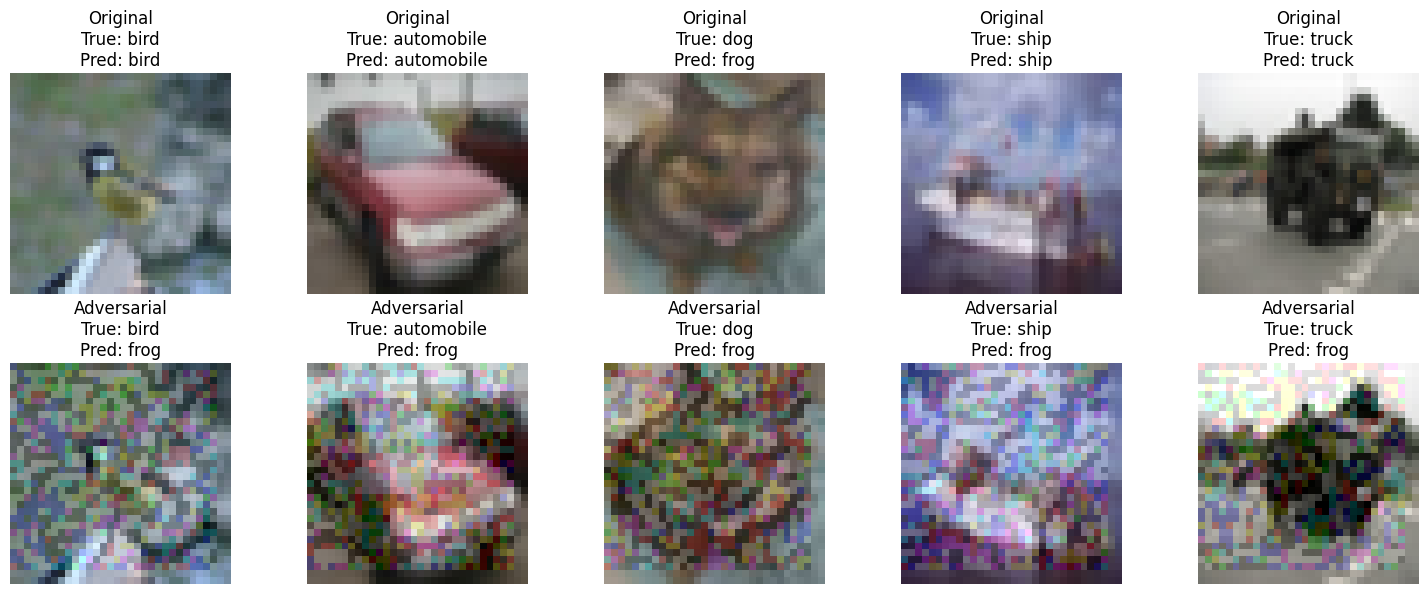


=== Visualizing Attack Mechanics ===
Visualizing adversarial perturbations...


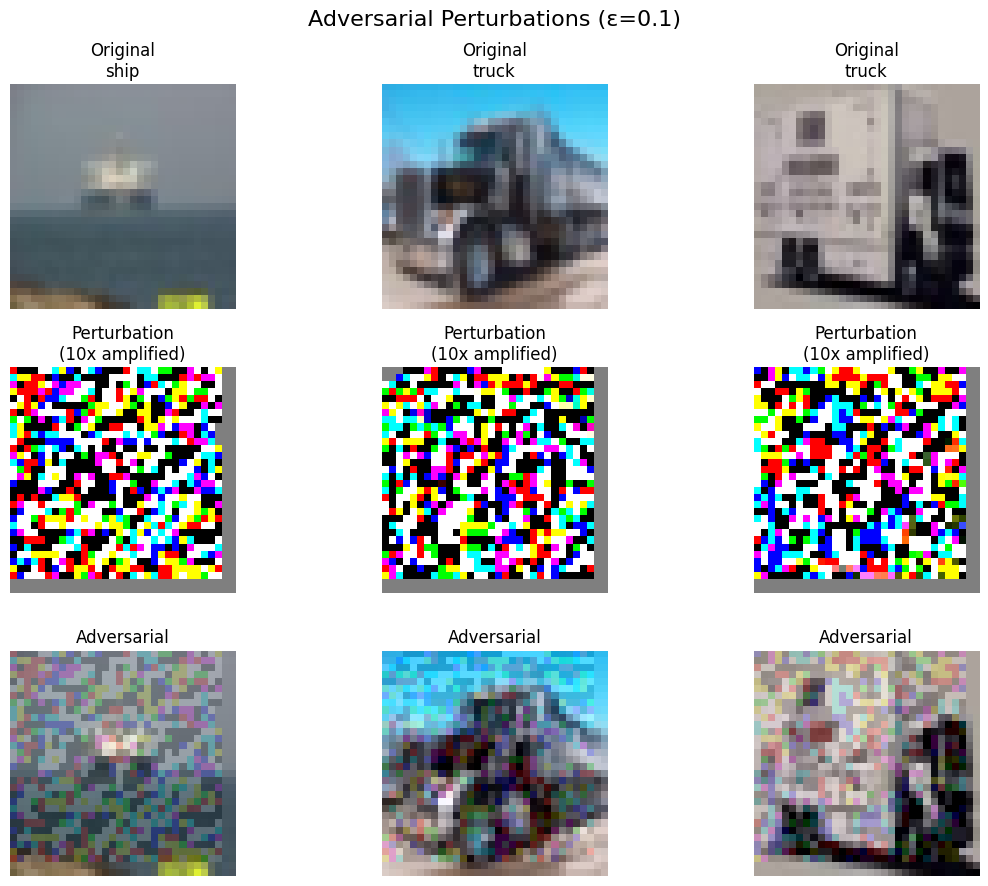

Visualizing gradient importance...


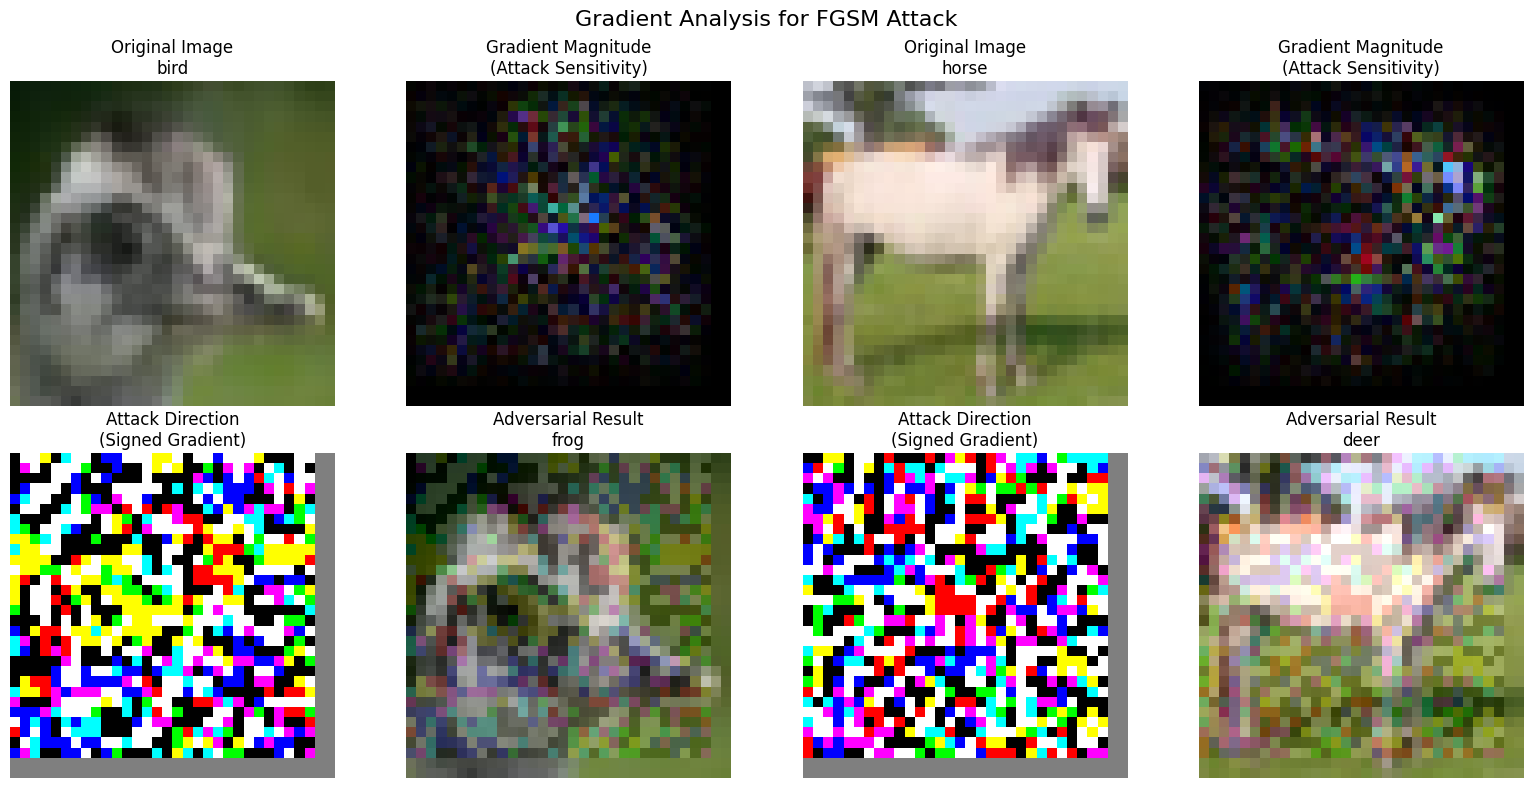


=== Analyzing Confidence Changes ===
Visualizing confidence changes...


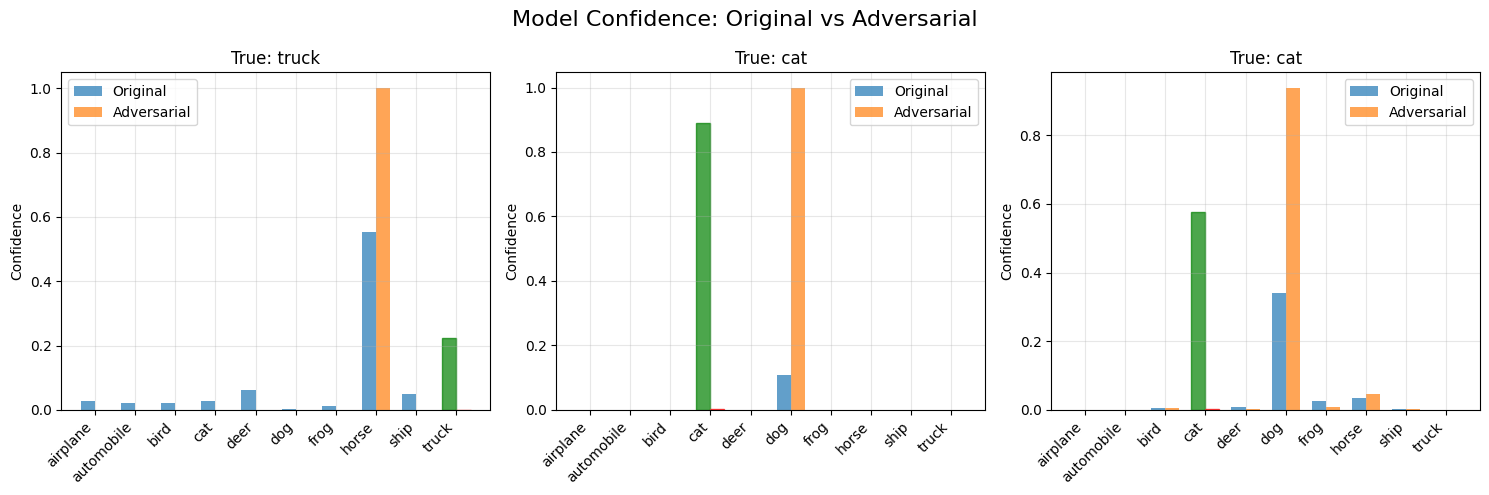


=== Evaluating Standard Model Robustness ===
Evaluating robustness with epsilon=0.1...
Original accuracy: 0.6690
Adversarial accuracy: 0.0090
Robustness drop: 0.6600

=== Attack Strength Analysis ===
Analyzing attack strength vs success rate...
Epsilon: 0.05, Attack Success Rate: 0.638
Epsilon: 0.10, Attack Success Rate: 0.638
Epsilon: 0.15, Attack Success Rate: 0.666
Epsilon: 0.20, Attack Success Rate: 0.638
Epsilon: 0.25, Attack Success Rate: 0.668


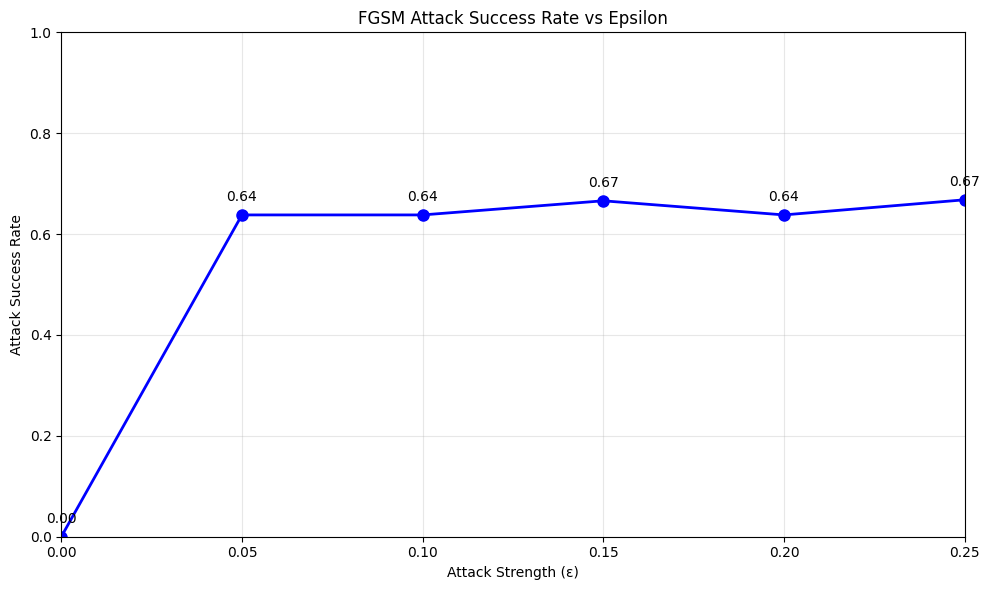


=== Class Vulnerability Analysis ===
Analyzing class-specific attack vulnerability...


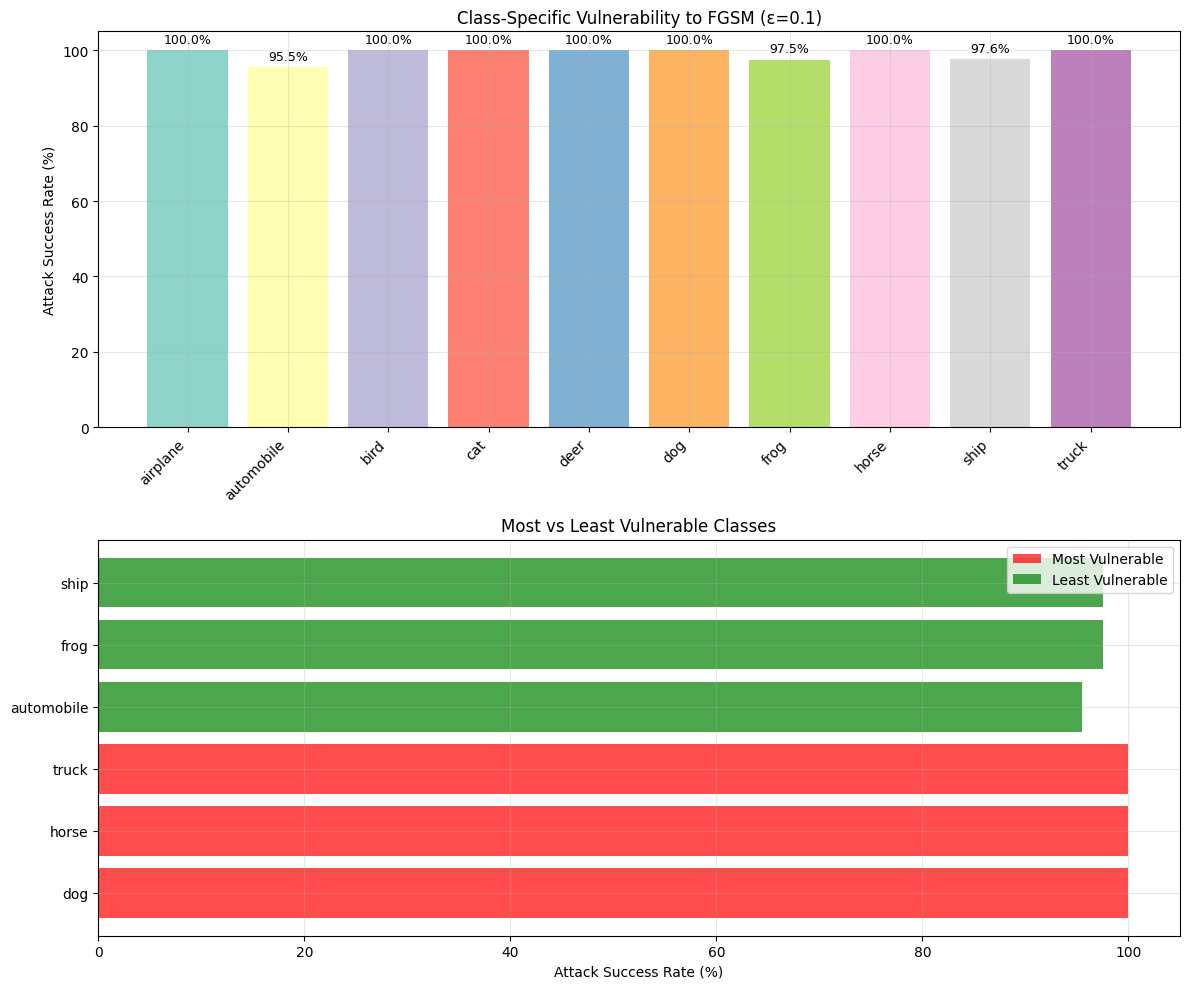


=== Training Robust Model ===
Training robust model with adversarial examples...
Epoch 1/5
Loss: 1.8382, Accuracy: 0.3158
Epoch 2/5
Loss: 1.5603, Accuracy: 0.4289
Epoch 3/5
Loss: 1.4474, Accuracy: 0.4737
Epoch 4/5
Loss: 1.3679, Accuracy: 0.5048
Epoch 5/5
Loss: 1.3050, Accuracy: 0.5296
Robust model test accuracy: 0.6368

=== Training Progress Comparison ===


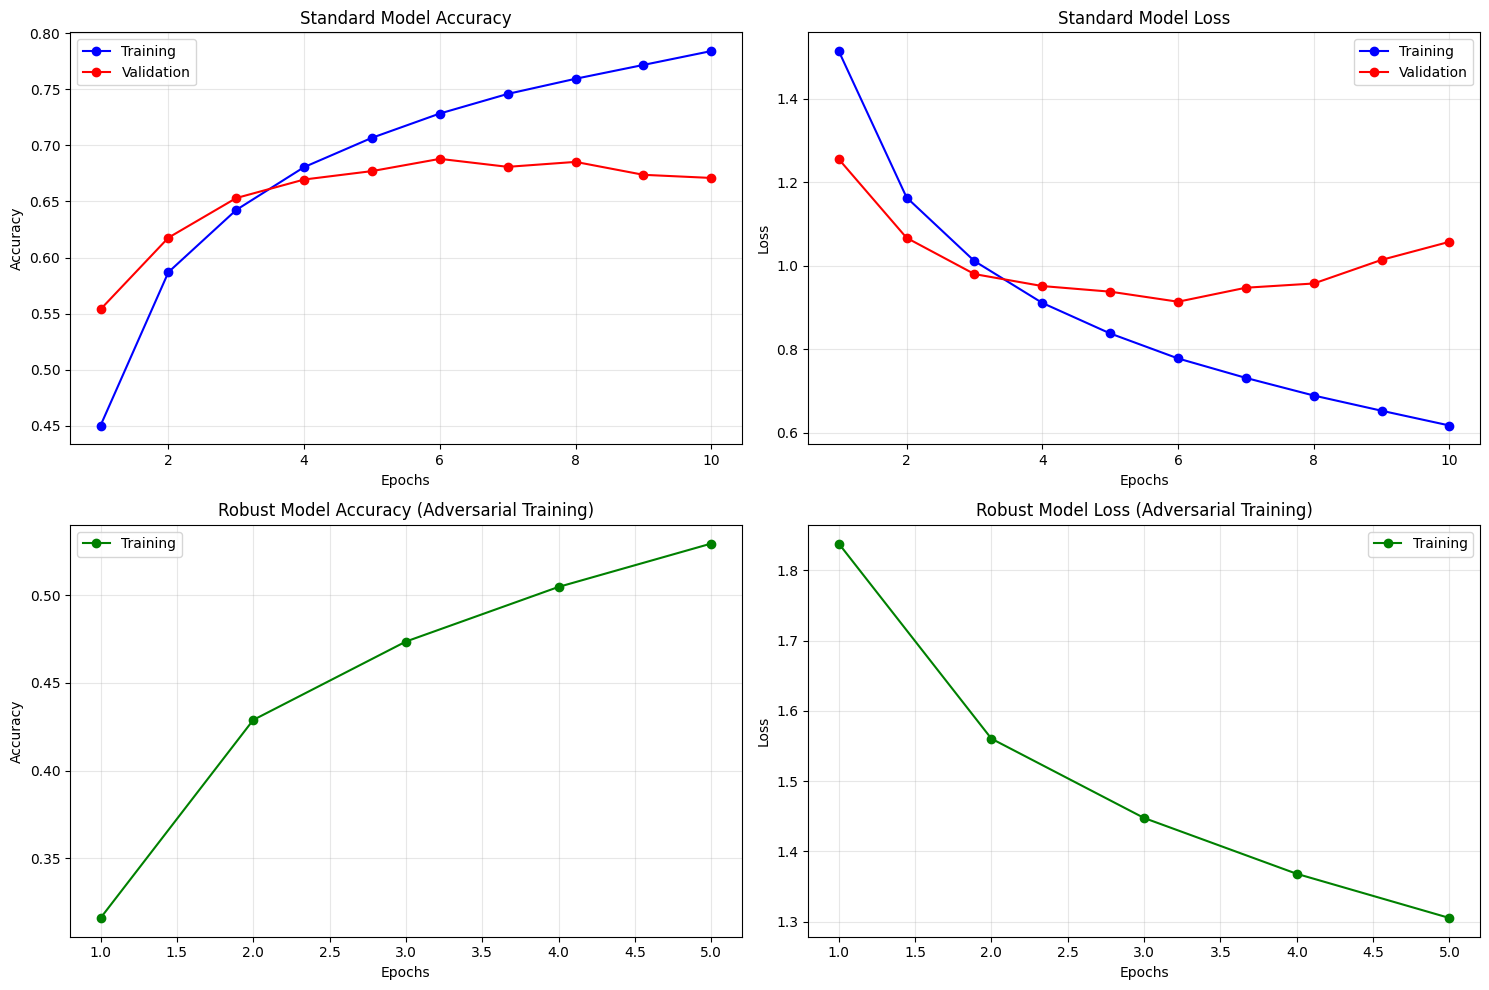


=== Model Comparison ===
Comparing standard vs robust model...

Model Comparison (epsilon=0.1):
Standard Model - Clean: 0.6650, Adversarial: 0.0040
Robust Model   - Clean: 0.6560, Adversarial: 0.5110

Robustness Improvement: 0.5070

=== Model Performance Visualization ===
Creating model performance comparison chart...


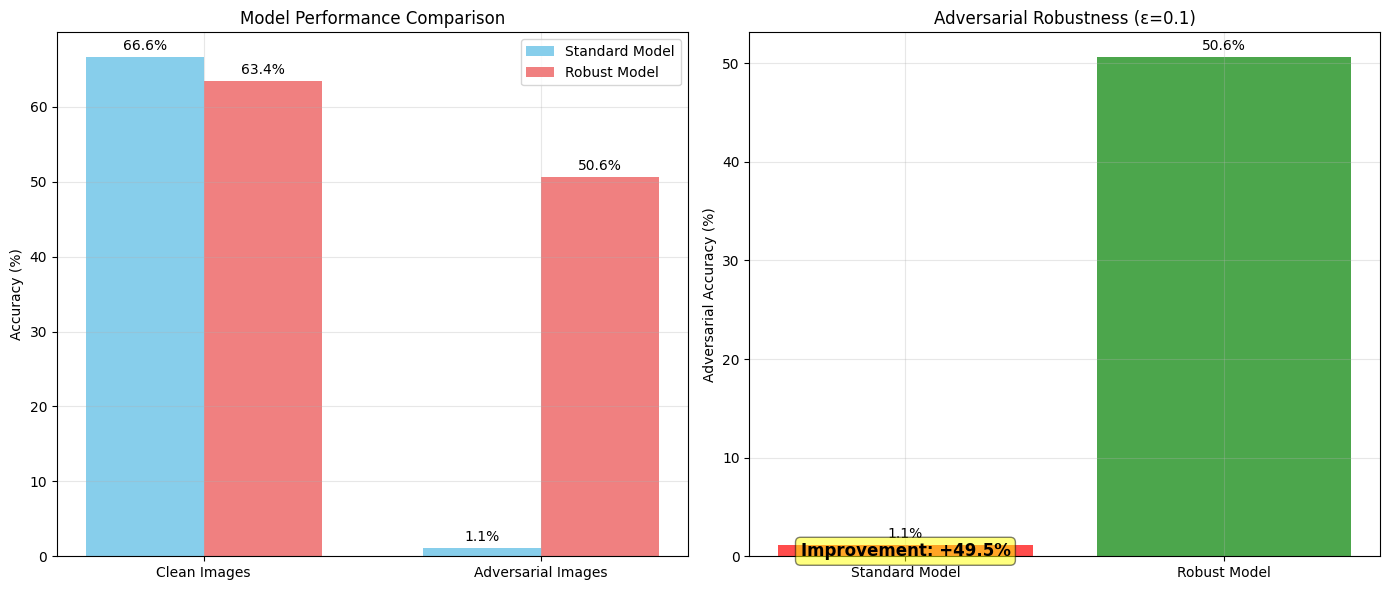


=== Demo Complete ===

=== Testing Different Attack Strengths ===

Epsilon = 0.05
Evaluating robustness with epsilon=0.05...
Original accuracy: 0.6680
Adversarial accuracy: 0.0040
Robustness drop: 0.6640

Epsilon = 0.1
Evaluating robustness with epsilon=0.1...
Original accuracy: 0.6820
Adversarial accuracy: 0.0160
Robustness drop: 0.6660

Epsilon = 0.15
Evaluating robustness with epsilon=0.15...
Original accuracy: 0.6940
Adversarial accuracy: 0.0200
Robustness drop: 0.6740

Epsilon = 0.2
Evaluating robustness with epsilon=0.2...
Original accuracy: 0.7000
Adversarial accuracy: 0.0180
Robustness drop: 0.6820


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.datasets import cifar10 # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
import warnings
import seaborn as sns
from matplotlib.patches import Rectangle
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#Hyperparameter tuning
set_epsilon=0.1
set_epochs=10


class AdversarialMLDemo:
    def __init__(self):
        self.model = None
        self.robust_model = None
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                           'dog', 'frog', 'horse', 'ship', 'truck']
        # Store training history for visualization
        self.training_history = []
        self.robust_training_history = []
    
    def load_and_preprocess_data(self):
        """Load and preprocess CIFAR-10 dataset"""
        print("Loading CIFAR-10 dataset...")
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        
        # Normalize pixel values to [0, 1]
        self.x_train = x_train.astype('float32') / 255.0
        self.x_test = x_test.astype('float32') / 255.0
        
        # Convert labels to categorical
        self.y_train = to_categorical(y_train, 10)
        self.y_test = to_categorical(y_test, 10)
        
        print(f"Training data shape: {self.x_train.shape}")
        print(f"Test data shape: {self.x_test.shape}")
    
    def create_simple_cnn(self):
        """Create a simple CNN model"""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        
        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        return model
    
    def train_model(self, epochs=10):
        """Train the standard model"""
        print("Training standard model...")
        self.model = self.create_simple_cnn()
        
        history = self.model.fit(self.x_train, self.y_train,
                                epochs=epochs,
                                batch_size=32,
                                validation_data=(self.x_test, self.y_test),
                                verbose=1)
        
        # Store history for visualization
        self.training_history = history.history
        
        # Evaluate model
        test_loss, test_acc = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        print(f"Standard model test accuracy: {test_acc:.4f}")
        return history
    
    def fgsm_attack(self, image, label, epsilon=set_epsilon):
        """
        Fast Gradient Sign Method (FGSM) attack
        
        Args:
            image: Input image
            label: True label
            epsilon: Attack strength
        """
        image = tf.cast(image, tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = self.model(image)
            loss = tf.keras.losses.categorical_crossentropy(label, prediction)
        
        # Get the gradients of the loss w.r.t to the input image
        gradient = tape.gradient(loss, image)
        
        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
        
        # Create the perturbed image by adjusting each pixel of the input image
        adversarial_image = image + epsilon * signed_grad
        
        # Clip to ensure the image is still valid
        adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
        
        return adversarial_image
    
    def generate_adversarial_examples(self, num_examples=5, epsilon=set_epsilon):
        """Generate adversarial examples using FGSM"""
        print(f"Generating adversarial examples with epsilon={epsilon}...")
        
        # Select random test examples
        indices = np.random.choice(len(self.x_test), num_examples, replace=False)
        
        original_images = []
        adversarial_images = []
        original_predictions = []
        adversarial_predictions = []
        true_labels = []
        
        for idx in indices:
            # Get original image and label
            original_img = self.x_test[idx:idx+1]
            true_label = self.y_test[idx:idx+1]
            
            # Generate adversarial example
            adv_img = self.fgsm_attack(original_img, true_label, epsilon)
            
            # Get predictions
            orig_pred = self.model.predict(original_img, verbose=0)
            adv_pred = self.model.predict(adv_img, verbose=0)
            
            original_images.append(original_img[0])
            adversarial_images.append(adv_img[0])
            original_predictions.append(np.argmax(orig_pred))
            adversarial_predictions.append(np.argmax(adv_pred))
            true_labels.append(np.argmax(true_label))
        
        return (original_images, adversarial_images, 
                original_predictions, adversarial_predictions, true_labels)
    
    def visualize_adversarial_examples(self, original_imgs, adv_imgs, 
                                     orig_preds, adv_preds, true_labels):
        """Visualize original vs adversarial examples"""
        fig, axes = plt.subplots(2, len(original_imgs), figsize=(15, 6))
        
        for i in range(len(original_imgs)):
            # Original image
            axes[0, i].imshow(original_imgs[i])
            axes[0, i].set_title(f'Original\nTrue: {self.class_names[true_labels[i]]}\n'
                               f'Pred: {self.class_names[orig_preds[i]]}')
            axes[0, i].axis('off')
            
            # Adversarial image
            axes[1, i].imshow(adv_imgs[i])
            axes[1, i].set_title(f'Adversarial\nTrue: {self.class_names[true_labels[i]]}\n'
                               f'Pred: {self.class_names[adv_preds[i]]}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_robustness(self, epsilon=set_epsilon, num_samples=1000):
        """Evaluate model robustness against adversarial examples"""
        print(f"Evaluating robustness with epsilon={epsilon}...")
        
        # Select random samples
        indices = np.random.choice(len(self.x_test), num_samples, replace=False)
        
        correct_original = 0
        correct_adversarial = 0
        
        for idx in indices:
            original_img = self.x_test[idx:idx+1]
            true_label = self.y_test[idx:idx+1]
            
            # Generate adversarial example
            adv_img = self.fgsm_attack(original_img, true_label, epsilon)
            
            # Check predictions
            orig_pred = np.argmax(self.model.predict(original_img, verbose=0))
            adv_pred = np.argmax(self.model.predict(adv_img, verbose=0))
            true_class = np.argmax(true_label)
            
            if orig_pred == true_class:
                correct_original += 1
            if adv_pred == true_class:
                correct_adversarial += 1
        
        original_accuracy = correct_original / num_samples
        adversarial_accuracy = correct_adversarial / num_samples
        
        print(f"Original accuracy: {original_accuracy:.4f}")
        print(f"Adversarial accuracy: {adversarial_accuracy:.4f}")
        print(f"Robustness drop: {original_accuracy - adversarial_accuracy:.4f}")
        
        return original_accuracy, adversarial_accuracy
    
    def adversarial_training(self, epochs=5, epsilon=set_epsilon):
        """Train a robust model using adversarial training"""
        print("Training robust model with adversarial examples...")
        
        # Create new model
        self.robust_model = self.create_simple_cnn()
        
        batch_size = 32
        num_batches = len(self.x_train) // batch_size
        
        # Store training history for robust model
        robust_history = {'loss': [], 'accuracy': []}
        
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            epoch_loss = 0
            epoch_acc = 0
            
            for batch in range(num_batches):
                start_idx = batch * batch_size
                end_idx = start_idx + batch_size
                
                # Get batch
                x_batch = self.x_train[start_idx:end_idx]
                y_batch = self.y_train[start_idx:end_idx]
                
                # Generate adversarial examples for half the batch
                adv_indices = np.random.choice(batch_size, batch_size // 2, replace=False)
                
                x_adv_batch = x_batch.copy()
                for idx in adv_indices:
                    x_single = x_batch[idx:idx+1]
                    y_single = y_batch[idx:idx+1]
                    x_adv_batch[idx] = self.fgsm_attack(x_single, y_single, epsilon)[0]
                
                # Train on mixed batch (original + adversarial)
                x_mixed = np.concatenate([x_batch, x_adv_batch])
                y_mixed = np.concatenate([y_batch, y_batch])
                
                # Train step
                loss, acc = self.robust_model.train_on_batch(x_mixed, y_mixed)
                epoch_loss += loss
                epoch_acc += acc
            
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches
            robust_history['loss'].append(avg_loss)
            robust_history['accuracy'].append(avg_acc)
            print(f"Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
        
        self.robust_training_history = robust_history
        
        # Evaluate robust model
        test_loss, test_acc = self.robust_model.evaluate(self.x_test, self.y_test, verbose=0)
        print(f"Robust model test accuracy: {test_acc:.4f}")
    
    def compare_models(self, epsilon=set_epsilon, num_samples=1000):
        """Compare standard vs robust model performance"""
        print("Comparing standard vs robust model...")
        
        indices = np.random.choice(len(self.x_test), num_samples, replace=False)
        
        std_clean_acc = 0
        std_adv_acc = 0
        rob_clean_acc = 0
        rob_adv_acc = 0
        
        for idx in indices:
            original_img = self.x_test[idx:idx+1]
            true_label = self.y_test[idx:idx+1]
            true_class = np.argmax(true_label)
            
            # Generate adversarial example
            adv_img = self.fgsm_attack(original_img, true_label, epsilon)
            
            # Standard model predictions
            std_clean_pred = np.argmax(self.model.predict(original_img, verbose=0))
            std_adv_pred = np.argmax(self.model.predict(adv_img, verbose=0))
            
            # Robust model predictions
            rob_clean_pred = np.argmax(self.robust_model.predict(original_img, verbose=0))
            rob_adv_pred = np.argmax(self.robust_model.predict(adv_img, verbose=0))
            
            # Count correct predictions
            if std_clean_pred == true_class:
                std_clean_acc += 1
            if std_adv_pred == true_class:
                std_adv_acc += 1
            if rob_clean_pred == true_class:
                rob_clean_acc += 1
            if rob_adv_pred == true_class:
                rob_adv_acc += 1
        
        # Calculate accuracies
        std_clean_acc /= num_samples
        std_adv_acc /= num_samples
        rob_clean_acc /= num_samples
        rob_adv_acc /= num_samples
        
        print(f"\nModel Comparison (epsilon={epsilon}):")
        print(f"Standard Model - Clean: {std_clean_acc:.4f}, Adversarial: {std_adv_acc:.4f}")
        print(f"Robust Model   - Clean: {rob_clean_acc:.4f}, Adversarial: {rob_adv_acc:.4f}")
        print(f"\nRobustness Improvement: {rob_adv_acc - std_adv_acc:.4f}")
    
    # === NEW VISUALIZATION METHODS ===
    
    def visualize_perturbations(self, num_examples=3, epsilon=set_epsilon):
        """Visualize the actual perturbations (noise) added to images"""
        print("Visualizing adversarial perturbations...")
        
        indices = np.random.choice(len(self.x_test), num_examples, replace=False)
        
        fig, axes = plt.subplots(3, num_examples, figsize=(12, 9))
        fig.suptitle(f'Adversarial Perturbations (ε={epsilon})', fontsize=16)
        
        for i, idx in enumerate(indices):
            original_img = self.x_test[idx:idx+1]
            true_label = self.y_test[idx:idx+1]
            
            # Generate adversarial example
            adv_img = self.fgsm_attack(original_img, true_label, epsilon)
            
            # Calculate perturbation
            perturbation = adv_img[0] - original_img[0]
            
            # Original image
            axes[0, i].imshow(original_img[0])
            axes[0, i].set_title(f'Original\n{self.class_names[np.argmax(true_label)]}')
            axes[0, i].axis('off')
            
            # Perturbation (amplified for visibility)
            pert_vis = perturbation * 10 + 0.5  # Amplify and center at 0.5
            pert_vis = np.clip(pert_vis, 0, 1)
            axes[1, i].imshow(pert_vis)
            axes[1, i].set_title('Perturbation\n(10x amplified)')
            axes[1, i].axis('off')
            
            # Adversarial image
            axes[2, i].imshow(adv_img[0])
            axes[2, i].set_title('Adversarial')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_confidence_changes(self, num_examples=3, epsilon=set_epsilon):
        """Visualize how model confidence changes with adversarial examples"""
        print("Visualizing confidence changes...")
        
        indices = np.random.choice(len(self.x_test), num_examples, replace=False)
        
        fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
        fig.suptitle('Model Confidence: Original vs Adversarial', fontsize=16)
        
        for i, idx in enumerate(indices):
            original_img = self.x_test[idx:idx+1]
            true_label = self.y_test[idx:idx+1]
            true_class = np.argmax(true_label)
            
            # Generate adversarial example
            adv_img = self.fgsm_attack(original_img, true_label, epsilon)
            
            # Get prediction probabilities
            orig_probs = self.model.predict(original_img, verbose=0)[0]
            adv_probs = self.model.predict(adv_img, verbose=0)[0]
            
            # Create bar plot
            x = np.arange(len(self.class_names))
            width = 0.35
            
            bars1 = axes[i].bar(x - width/2, orig_probs, width, label='Original', alpha=0.7)
            bars2 = axes[i].bar(x + width/2, adv_probs, width, label='Adversarial', alpha=0.7)
            
            # Highlight true class
            bars1[true_class].set_color('green')
            bars2[true_class].set_color('red')
            
            axes[i].set_ylabel('Confidence')
            axes[i].set_title(f'True: {self.class_names[true_class]}')
            axes[i].set_xticks(x)
            axes[i].set_xticklabels(self.class_names, rotation=45, ha='right')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_attack_strength_analysis(self, epsilons=[0.0, 0.05, 0.1, 0.15, 0.2, 0.25]):
        """Analyze how attack strength (epsilon) affects success rate"""
        print("Analyzing attack strength vs success rate...")
        
        success_rates = []
        num_samples = 500
        
        for eps in epsilons:
            if eps == 0.0:
                success_rates.append(0.0)  # No attack
                continue
                
            indices = np.random.choice(len(self.x_test), num_samples, replace=False)
            successful_attacks = 0
            
            for idx in indices:
                original_img = self.x_test[idx:idx+1]
                true_label = self.y_test[idx:idx+1]
                true_class = np.argmax(true_label)
                
                # Check if original prediction is correct
                orig_pred = np.argmax(self.model.predict(original_img, verbose=0))
                if orig_pred != true_class:
                    continue  # Skip if original prediction was wrong
                
                # Generate adversarial example
                adv_img = self.fgsm_attack(original_img, true_label, eps)
                adv_pred = np.argmax(self.model.predict(adv_img, verbose=0))
                
                if adv_pred != true_class:
                    successful_attacks += 1
            
            success_rate = successful_attacks / num_samples
            success_rates.append(success_rate)
            print(f"Epsilon: {eps:.2f}, Attack Success Rate: {success_rate:.3f}")
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(epsilons, success_rates, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Attack Strength (ε)')
        plt.ylabel('Attack Success Rate')
        plt.title('FGSM Attack Success Rate vs Epsilon')
        plt.grid(True, alpha=0.3)
        plt.xlim(0, max(epsilons))
        plt.ylim(0, 1)
        
        # Add annotations
        for i, (eps, rate) in enumerate(zip(epsilons, success_rates)):
            plt.annotate(f'{rate:.2f}', (eps, rate), textcoords="offset points", 
                        xytext=(0,10), ha='center')
        
        plt.tight_layout()
        plt.show()
        
        return epsilons, success_rates
    
    def visualize_gradient_importance(self, num_examples=2, epsilon=set_epsilon):
        """Visualize gradient importance and attack direction"""
        print("Visualizing gradient importance...")
        
        indices = np.random.choice(len(self.x_test), num_examples, replace=False)
        
        fig, axes = plt.subplots(2, num_examples * 2, figsize=(16, 8))
        fig.suptitle('Gradient Analysis for FGSM Attack', fontsize=16)
        
        for i, idx in enumerate(indices):
            original_img = self.x_test[idx:idx+1]
            true_label = self.y_test[idx:idx+1]
            
            # Calculate gradients
            image = tf.cast(original_img, tf.float32)
            with tf.GradientTape() as tape:
                tape.watch(image)
                prediction = self.model(image)
                loss = tf.keras.losses.categorical_crossentropy(true_label, prediction)
            
            gradient = tape.gradient(loss, image)
            signed_grad = tf.sign(gradient)
            
            # Original image
            axes[0, i*2].imshow(original_img[0])
            axes[0, i*2].set_title(f'Original Image\n{self.class_names[np.argmax(true_label)]}')
            axes[0, i*2].axis('off')
            
            # Gradient magnitude
            grad_mag = np.abs(gradient[0])
            grad_mag = grad_mag / np.max(grad_mag)  # Normalize
            axes[0, i*2+1].imshow(grad_mag, cmap='hot')
            axes[0, i*2+1].set_title('Gradient Magnitude\n(Attack Sensitivity)')
            axes[0, i*2+1].axis('off')
            
            # Signed gradient
            signed_grad_vis = signed_grad[0] * 0.5 + 0.5  # Convert from [-1,1] to [0,1]
            axes[1, i*2].imshow(signed_grad_vis)
            axes[1, i*2].set_title('Attack Direction\n(Signed Gradient)')
            axes[1, i*2].axis('off')
            
            # Adversarial example
            adv_img = self.fgsm_attack(original_img, true_label, epsilon)
            adv_pred = self.model.predict(adv_img, verbose=0)
            axes[1, i*2+1].imshow(adv_img[0])
            axes[1, i*2+1].set_title(f'Adversarial Result\n{self.class_names[np.argmax(adv_pred)]}')
            axes[1, i*2+1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_model_comparison_chart(self, epsilon=set_epsilon):
        """Create bar chart comparing model performance"""
        print("Creating model performance comparison chart...")
        
        # Get performance metrics
        num_samples = 1000
        indices = np.random.choice(len(self.x_test), num_samples, replace=False)
        
        std_clean, std_adv, rob_clean, rob_adv = 0, 0, 0, 0
        
        for idx in indices:
            original_img = self.x_test[idx:idx+1]
            true_label = self.y_test[idx:idx+1]
            true_class = np.argmax(true_label)
            
            adv_img = self.fgsm_attack(original_img, true_label, epsilon)
            
            # Standard model predictions
            if np.argmax(self.model.predict(original_img, verbose=0)) == true_class:
                std_clean += 1
            if np.argmax(self.model.predict(adv_img, verbose=0)) == true_class:
                std_adv += 1
            
            # Robust model predictions
            if np.argmax(self.robust_model.predict(original_img, verbose=0)) == true_class:
                rob_clean += 1
            if np.argmax(self.robust_model.predict(adv_img, verbose=0)) == true_class:
                rob_adv += 1
        
        # Convert to percentages
        std_clean, std_adv = std_clean/num_samples*100, std_adv/num_samples*100
        rob_clean, rob_adv = rob_clean/num_samples*100, rob_adv/num_samples*100
        
        # Create comparison chart
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Accuracy comparison
        categories = ['Clean Images', 'Adversarial Images']
        std_scores = [std_clean, std_adv]
        rob_scores = [rob_clean, rob_adv]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, std_scores, width, label='Standard Model', color='skyblue')
        bars2 = ax1.bar(x + width/2, rob_scores, width, label='Robust Model', color='lightcoral')
        
        ax1.set_ylabel('Accuracy (%)')
        ax1.set_title('Model Performance Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax1.annotate(f'{height:.1f}%',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3), textcoords="offset points",
                           ha='center', va='bottom')
        
        # Robustness improvement chart
        categories2 = ['Standard Model', 'Robust Model']
        adv_performance = [std_adv, rob_adv]
        colors = ['red', 'green']
        
        bars3 = ax2.bar(categories2, adv_performance, color=colors, alpha=0.7)
        ax2.set_ylabel('Adversarial Accuracy (%)')
        ax2.set_title(f'Adversarial Robustness (ε={epsilon})')
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for bar in bars3:
            height = bar.get_height()
            ax2.annotate(f'{height:.1f}%',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom')
        
        # Add improvement annotation
        improvement = rob_adv - std_adv
        ax2.annotate(f'Improvement: +{improvement:.1f}%',
                   xy=(0.5, max(adv_performance) * 0.8), xytext=(0, 0),
                   ha='center', fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
    
    def visualize_class_confusion_analysis(self, epsilon=set_epsilon, num_samples=500):
        """Analyze which classes are most vulnerable to attacks"""
        print("Analyzing class-specific attack vulnerability...")
        
        confusion_data = {}
        for class_idx in range(10):
            confusion_data[class_idx] = {'correct': 0, 'attacked': 0, 'total': 0}
        
        # Get samples for each class
        for true_class in range(10):
            class_indices = np.where(np.argmax(self.y_test, axis=1) == true_class)[0]
            selected_indices = np.random.choice(class_indices, 
                                              min(num_samples//10, len(class_indices)), 
                                              replace=False)
            
            for idx in selected_indices:
                original_img = self.x_test[idx:idx+1]
                true_label = self.y_test[idx:idx+1]
                
                # Check original prediction
                orig_pred = np.argmax(self.model.predict(original_img, verbose=0))
                if orig_pred == true_class:
                    confusion_data[true_class]['correct'] += 1
                    
                    # Generate adversarial example
                    adv_img = self.fgsm_attack(original_img, true_label, epsilon)
                    adv_pred = np.argmax(self.model.predict(adv_img, verbose=0))
                    
                    if adv_pred != true_class:
                        confusion_data[true_class]['attacked'] += 1
                
                confusion_data[true_class]['total'] += 1
        
        # Calculate vulnerability rates
        class_names = self.class_names
        vulnerability_rates = []
        
        for class_idx in range(10):
            if confusion_data[class_idx]['correct'] > 0:
                vuln_rate = confusion_data[class_idx]['attacked'] / confusion_data[class_idx]['correct']
            else:
                vuln_rate = 0
            vulnerability_rates.append(vuln_rate * 100)
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Vulnerability by class
        colors = plt.cm.Set3(np.arange(10))
        bars = ax1.bar(class_names, vulnerability_rates, color=colors)
        ax1.set_ylabel('Attack Success Rate (%)')
        ax1.set_title(f'Class-Specific Vulnerability to FGSM (ε={epsilon})')
        ax1.set_xticklabels(class_names, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, rate in zip(bars, vulnerability_rates):
            ax1.annotate(f'{rate:.1f}%',
                       xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)
        
        # Most vs least vulnerable
        sorted_classes = sorted(zip(class_names, vulnerability_rates), key=lambda x: x[1])
        most_vulnerable = sorted_classes[-3:]  # Top 3 most vulnerable
        least_vulnerable = sorted_classes[:3]   # Top 3 least vulnerable
        
        categories = ['Most Vulnerable', 'Least Vulnerable']
        most_rates = [x[1] for x in most_vulnerable]
        least_rates = [x[1] for x in least_vulnerable]
        
        ax2.barh([f"{x[0]}" for x in most_vulnerable], most_rates, 
                color='red', alpha=0.7, label='Most Vulnerable')
        ax2.barh([f"{x[0]}" for x in least_vulnerable], least_rates, 
                color='green', alpha=0.7, label='Least Vulnerable')
        
        ax2.set_xlabel('Attack Success Rate (%)')
        ax2.set_title('Most vs Least Vulnerable Classes')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return vulnerability_rates
    
    def visualize_training_progress(self):
        """Visualize training progress for both models"""
        if not self.training_history or not self.robust_training_history:
            print("No training history available. Train both models first.")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Standard model training progress
        epochs = range(1, len(self.training_history['accuracy']) + 1)
        ax1.plot(epochs, self.training_history['accuracy'], 'bo-', label='Training')
        ax1.plot(epochs, self.training_history['val_accuracy'], 'ro-', label='Validation')
        ax1.set_title('Standard Model Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(epochs, self.training_history['loss'], 'bo-', label='Training')
        ax2.plot(epochs, self.training_history['val_loss'], 'ro-', label='Validation')
        ax2.set_title('Standard Model Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Robust model training progress
        rob_epochs = range(1, len(self.robust_training_history['accuracy']) + 1)
        ax3.plot(rob_epochs, self.robust_training_history['accuracy'], 'go-', label='Training')
        ax3.set_title('Robust Model Accuracy (Adversarial Training)')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Accuracy')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        ax4.plot(rob_epochs, self.robust_training_history['loss'], 'go-', label='Training')
        ax4.set_title('Robust Model Loss (Adversarial Training)')
        ax4.set_xlabel('Epochs')
        ax4.set_ylabel('Loss')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def run_full_demo(self):
        """Run the complete adversarial ML demonstration"""
        print("=== Adversarial ML Attack and Defense Demo ===\n")
        
        # 1. Load data and train standard model
        self.load_and_preprocess_data()
        self.train_model(epochs=10)
        
        # 2. Generate and visualize adversarial examples
        print("\n=== Generating Adversarial Examples ===")
        orig_imgs, adv_imgs, orig_preds, adv_preds, true_labels = \
            self.generate_adversarial_examples(num_examples=5, epsilon=set_epsilon)
        
        self.visualize_adversarial_examples(orig_imgs, adv_imgs, 
                                          orig_preds, adv_preds, true_labels)
        
        # 3. NEW: Visualize perturbations and gradients
        print("\n=== Visualizing Attack Mechanics ===")
        self.visualize_perturbations(num_examples=3, epsilon=set_epsilon)
        self.visualize_gradient_importance(num_examples=2, epsilon=set_epsilon)
        
        # 4. NEW: Confidence analysis
        print("\n=== Analyzing Confidence Changes ===")
        self.visualize_confidence_changes(num_examples=3, epsilon=set_epsilon)
        
        # 5. Evaluate standard model robustness
        print("\n=== Evaluating Standard Model Robustness ===")
        self.evaluate_robustness(epsilon=set_epsilon, num_samples=1000)
        
        # 6. NEW: Attack strength analysis
        print("\n=== Attack Strength Analysis ===")
        self.visualize_attack_strength_analysis()
        
        # 7. NEW: Class vulnerability analysis
        print("\n=== Class Vulnerability Analysis ===")
        self.visualize_class_confusion_analysis(epsilon=set_epsilon)
        
        # 8. Train robust model with adversarial training
        print("\n=== Training Robust Model ===")
        self.adversarial_training(epochs=5, epsilon=set_epsilon)
        
        # 9. NEW: Training progress visualization
        print("\n=== Training Progress Comparison ===")
        self.visualize_training_progress()
        
        # 10. Compare models
        print("\n=== Model Comparison ===")
        self.compare_models(epsilon=set_epsilon, num_samples=1000)
        
        # 11. NEW: Model comparison chart
        print("\n=== Model Performance Visualization ===")
        self.visualize_model_comparison_chart(epsilon=set_epsilon)
        
        print("\n=== Demo Complete ===")

# Usage example
if __name__ == "__main__":
    # Create and run the demo
    demo = AdversarialMLDemo()
    demo.run_full_demo()
    
    # Optional: Test with different epsilon values
    print("\n=== Testing Different Attack Strengths ===")
    for eps in [0.05, 0.1, 0.15, 0.2]:
        print(f"\nEpsilon = {eps}")
        demo.evaluate_robustness(epsilon=eps, num_samples=500)